# guidance for Gaussian process regression

In this part, two single fidelity gpr models will be introduced. The first model
is Kriging model which aims to model the noiseless case; the second model is Gaussian process regressor which aims to model the case with noise.


## Kriging model


In [1]:
# third party packages
import matplotlib.pyplot as plt
import numpy as np

# local funstions
from mfpml.models.gaussian_process import GaussianProcessRegression
from mfpml.problems.singlefidelity_functions import Forrester
from mfpml.models.kernels import RBF
from mfpml.models.basis_functions import Ordinary, Linear, Quadratic

In [2]:
# define function
func = Forrester()

# initialize sampler

sample_x = np.array([0.0, 0.4, 0.6, 1.0]).reshape((-1, 1))
test_x = np.linspace(0, 1, 1001, endpoint=True).reshape(-1, 1)

# get the function value
sample_y = func.f(sample_x)
test_y = func.f(test_x)

In [3]:
# train the model
sfK = GaussianProcessRegression(design_space=func._input_domain,
                                optimizer_restart=20,
                                noise_prior=0.0)
sfK.train(sample_x, sample_y)
sf_pre, sf_std = sfK.predict(test_x, return_std=True)

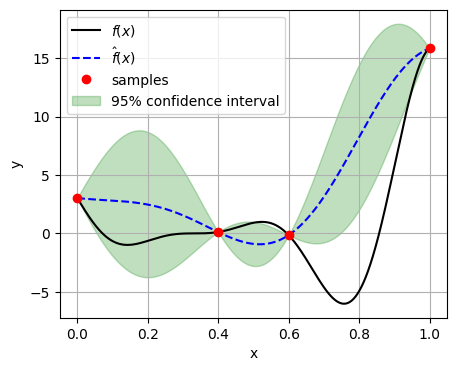

In [4]:
# plot the prediction
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(test_x, test_y, "k-", label=r"$f(x)$")
ax.plot(test_x, sf_pre, "b--", label=r"$\hat{f}(x)$")
ax.plot(sample_x, sample_y, "ro", label="samples")
ax.fill_between(
    test_x.reshape(-1),
    (sf_pre - 1.96 * sf_std).reshape(-1),
    (sf_pre + 1.96 * sf_std).reshape(-1),
    alpha=0.25,
    color="g",
    label="95% confidence interval",
)
ax.legend(loc="best")
ax.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [5]:
gpr = GaussianProcessRegression(
    design_space=func._input_domain,
    regr=Ordinary(),
    optimizer_restart=5, noise_prior=0.0
)
gpr.train(sample_x, sample_y)
gpr_pre, gpr_std = gpr.predict(test_x, return_std=True)

In [6]:
gpr.training_time

0.05141758918762207

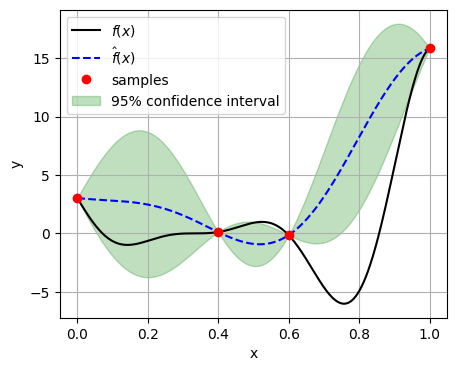

In [7]:
# plot the prediction
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(test_x, test_y, "k-", label=r"$f(x)$")
ax.plot(test_x, gpr_pre, "b--", label=r"$\hat{f}(x)$")
ax.plot(sample_x, sample_y, "ro", label="samples")
ax.fill_between(
    test_x.reshape(-1),
    (gpr_pre - 1.96 * gpr_std).reshape(-1),
    (gpr_pre + 1.96 * gpr_std).reshape(-1),
    alpha=0.25,
    color="g",
    label="95% confidence interval",
)
ax.legend(loc="best")
ax.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

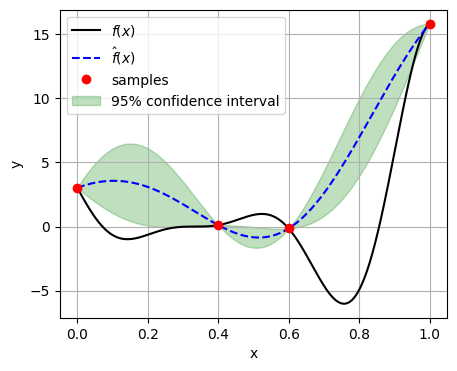

In [8]:
# advanced usage
# of course, you can change both the kernel, basis function and optimizer as
# you like to get the best performance
kernel = RBF(theta=np.zeros(func.num_dim))
basis = Linear()
# train the model
kriging = GaussianProcessRegression(design_space=func._input_domain,
                  kernel=kernel,
                  regr=basis,
                  optimizer_restart=20,
                  noise_prior=0.0)
kriging.train(sample_x, sample_y)
# predict
pre, std = kriging.predict(test_x, return_std=True)
# plot the prediction
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(test_x, test_y, "k-", label=r"$f(x)$")
ax.plot(test_x, pre, "b--", label=r"$\hat{f}(x)$")
ax.plot(sample_x, sample_y, "ro", label="samples")
ax.fill_between(
    test_x.reshape(-1),
    (pre - 1.96 * std).reshape(-1),
    (pre + 1.96 * std).reshape(-1),
    alpha=0.25,
    color="g",
    label="95% confidence interval",
)
ax.legend(loc="best")
ax.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Gaussian process regression model


In [9]:
from mfpml.models.gaussian_process import GaussianProcessRegression
from mfpml.optimization.evolutionary_algorithms import DE
from mfpml.design_of_experiment.singlefideliy_samplers import LatinHyperCube

In [10]:
# sampling by sampling method
sampler = LatinHyperCube(design_space=func._input_domain)
sample_x = sampler.get_samples(num_samples=30)
test_x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)

# get samples by adding noise to the true function
sample_y = func.f(sample_x) + np.random.normal(0, 0.2,
                                               sample_x.shape[0]).reshape((-1, 1))
test_y = func.f(test_x) + np.random.normal(0, 0.2,
                                           test_x.shape[0]).reshape((-1, 1))
test_mean = func.f(test_x)

In [11]:
# initialize optimizer
optimizer = DE(num_gen=1000, num_pop=50, crossover_rate=0.5,
               strategy="DE/best/1/bin")
# initialize the regressor
gp_model = GaussianProcessRegression(
    design_space=func._input_domain, optimizer_restart=20, noise_prior=None)
# train the model
gp_model.train(sample_x, sample_y)
# get the prediction
sf_pre, sf_std = gp_model.predict(test_x, return_std=True)

In [12]:
# output the learned noise level
print(gp_model.noise)

0.19165624126985142


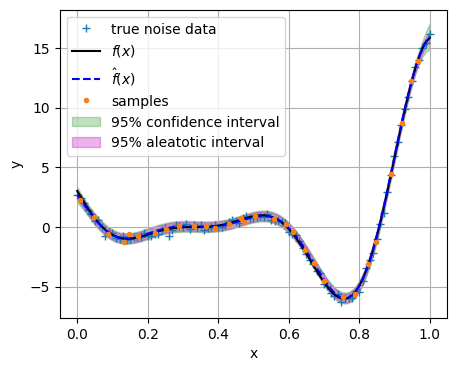

In [13]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(test_x, test_y, "+", label="true noise data")
ax.plot(test_x, test_mean, "k-", label=r"$f(x)$")
ax.plot(test_x, sf_pre, "b--", label=r"$\hat{f}(x)$")
ax.plot(sample_x, sample_y, ".", label="samples")
ax.fill_between(
    test_x.reshape(-1),
    (sf_pre - 1.96 * sf_std).reshape(-1),
    (sf_pre + 1.96 * sf_std).reshape(-1),
    alpha=0.25,
    color="g",
    label="95% confidence interval",
)
ax.fill_between(
    test_x.reshape(-1),
    (sf_pre - 1.96 * gp_model.noise).reshape(-1),
    (sf_pre + 1.96 * gp_model.noise).reshape(-1),
    alpha=0.3,
    color="m",
    label="95% aleatotic interval",
)
ax.legend(loc="best")
ax.grid('--')
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("mix_kriging.png", dpi=300, bbox_inches="tight")
plt.show()

In [14]:
# fix noise case, meaning the noise level is known
gp_model_know_noise = GaussianProcessRegression(
    design_space=func._input_domain, optimizer=optimizer, noise_prior=0.2)
# train the model
gp_model_know_noise.train(sample_x, sample_y)
# get the prediction
sf_pre, sf_std = gp_model_know_noise.predict(test_x, return_std=True)

In [15]:
gp_model_know_noise.noise

0.2

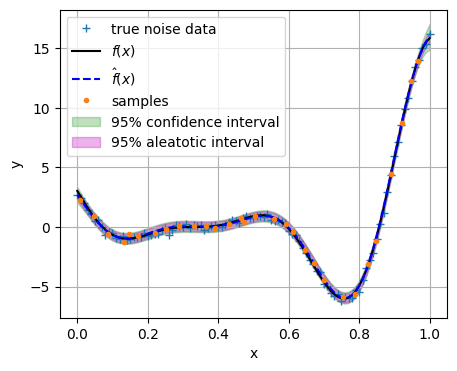

In [16]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(test_x, test_y, "+", label="true noise data")
ax.plot(test_x, test_mean, "k-", label=r"$f(x)$")
ax.plot(test_x, sf_pre, "b--", label=r"$\hat{f}(x)$")
ax.plot(sample_x, sample_y, ".", label="samples")
ax.fill_between(
    test_x.reshape(-1),
    (sf_pre - 1.96 * sf_std).reshape(-1),
    (sf_pre + 1.96 * sf_std).reshape(-1),
    alpha=0.25,
    color="g",
    label="95% confidence interval",
)
ax.fill_between(
    test_x.reshape(-1),
    (sf_pre - 1.96 * gp_model_know_noise.noise).reshape(-1),
    (sf_pre + 1.96 * gp_model_know_noise.noise).reshape(-1),
    alpha=0.3,
    color="m",
    label="95% aleatotic interval",
)
ax.legend(loc="best")
ax.grid('--')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [17]:
# change basis function
# fix noise case, meaning the noise level is known
gp_model_linear = GaussianProcessRegression(
    design_space=func._input_domain, regr=Quadratic(), noise_prior=None)
# train the model
gp_model_linear.train(sample_x, sample_y)
# get the prediction
sf_pre, sf_std = gp_model_linear.predict(test_x, return_std=True)

# print the learned noise level
print(gp_model_linear.noise)

0.20165676627873383


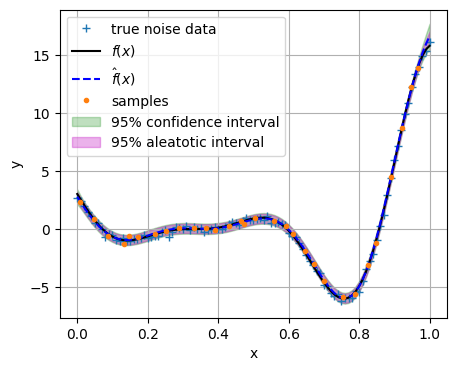

In [18]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(test_x, test_y, "+", label="true noise data")
ax.plot(test_x, test_mean, "k-", label=r"$f(x)$")
ax.plot(test_x, sf_pre, "b--", label=r"$\hat{f}(x)$")
ax.plot(sample_x, sample_y, ".", label="samples")
ax.fill_between(
    test_x.reshape(-1),
    (sf_pre - 1.96 * sf_std).reshape(-1),
    (sf_pre + 1.96 * sf_std).reshape(-1),
    alpha=0.25,
    color="g",
    label="95% confidence interval",
)
ax.fill_between(
    test_x.reshape(-1),
    (sf_pre - 1.96 * gp_model_linear.noise).reshape(-1),
    (sf_pre + 1.96 * gp_model_linear.noise).reshape(-1),
    alpha=0.3,
    color="m",
    label="95% aleatotic interval",
)
ax.legend(loc="best")
ax.grid('--')
plt.xlabel("x")
plt.ylabel("y")
plt.show()